**Implementation**
Concept - Federated Learning, Homomorphic Encryption
;Data - Loan Default Data
;Model - Tensorflow Keras Sequential Neural Network Model
;Custom Functions - Generate Clients, Add Samples to existing clients

**Import cleaned dataset, remove NA values, and split dataset into training and holdout set**

In [1]:
#Import normalized dataset and divide into x (predictors) and y(predicted)
import numpy as np
import pandas as pd
df = pd.read_csv('dataset.csv',header= None,skiprows=1)

In [2]:
#Dataframe with 32581 observations having 11 features and 1 predicted variable (loan default)
df.shape

(32581, 12)

In [3]:
#Check dataframe for null values and drop null values
df
df.isnull().any()
df2 = df.dropna()
df2.shape

(28638, 12)

In [4]:
#Check shape of new dataframe
df2.shape

(28638, 12)

In [5]:
#Check new dataframe
df2

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.016129,0.009173,1.000000,1.000000,0.595506,0.59,1,0,0,0,1,1
1,0.008065,0.000934,0.040650,0.014493,0.321348,0.10,0,0,0,1,0,0
2,0.040323,0.000934,0.008130,0.144928,0.418539,0.57,0,1,0,0,0,1
3,0.024194,0.010257,0.032520,1.000000,0.551124,0.53,0,0,0,0,1,1
4,0.032258,0.008406,0.065041,1.000000,0.497191,0.55,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,0.298387,0.008172,0.008130,0.153623,0.434831,0.11,0,1,0,0,0,0
32577,0.274194,0.019346,0.032520,0.496377,0.116292,0.15,0,1,0,0,0,0
32578,0.362903,0.012008,0.024390,1.000000,0.312921,0.46,0,0,0,0,1,1
32579,0.290323,0.024350,0.040650,0.420290,0.340449,0.10,0,1,0,0,0,0


In [6]:
#Create a holdout set for evaluation to find loss and accuracy at each aggregator epoch
from sklearn.model_selection import train_test_split
df_train, df_holdout = train_test_split(df2, test_size=0.3, random_state=42)
df_train.shape,df_holdout.shape

((20046, 12), (8592, 12))

In [7]:
#Define x_holdout and y_holdout from df_holdout

x_holdout = df_holdout.drop(df_holdout.columns[11], axis=1)
y_holdout = df_holdout[df_holdout.columns[11]]
df_holdout.shape,x_holdout.shape,y_holdout.shape
y_holdout.value_counts()

11
0    6715
1    1877
Name: count, dtype: int64

In [8]:
#Convert x_holdout and y_holdout to array
x_holdout = x_holdout.to_numpy()
y_holdout = y_holdout.to_numpy()
type(x_holdout),type(y_holdout)

(numpy.ndarray, numpy.ndarray)

In [9]:
#Check shape of training set
df_train.shape

(20046, 12)

In [10]:
# Drop predicted variable to create x
x1 = df_train.drop(df.columns[11], axis=1)
# Keep predicted variable to create y
y1 = df_train[df_train.columns[11]]

In [11]:
#Convert x and y from dataframe to numpy array and check if conversion is successful
x = x1.to_numpy()
y = y1.to_numpy()
type(x),type(y)

(numpy.ndarray, numpy.ndarray)

In [12]:
x,y

(array([[0.12903226, 0.07104737, 0.01626016, ..., 0.        , 0.        ,
         1.        ],
        [0.08064516, 0.00733823, 0.00813008, ..., 0.        , 0.        ,
         1.        ],
        [0.03225807, 0.00957305, 0.00813008, ..., 0.        , 0.        ,
         1.        ],
        ...,
        [0.01612903, 0.00333556, 0.00813008, ..., 0.        , 1.        ,
         0.        ],
        [0.08064516, 0.03685791, 0.01626016, ..., 0.        , 0.        ,
         1.        ],
        [0.10483871, 0.0188459 , 0.13821138, ..., 0.        , 0.        ,
         0.        ]]),
 array([0, 0, 0, ..., 0, 0, 0]))

**Build a client side model**

In [13]:
#Client side model
import tensorflow
def client_side_model(initial_weights = None):

  client_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Input((11,)),
    tensorflow.keras.layers.Dense(8, activation="relu"),
    tensorflow.keras.layers.Dense(1, activation="sigmoid")
  ])

  client_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

  if initial_weights != None:

    client_model.set_weights(initial_weights)

  return client_model

client_side_model()



**Build an Aggregator side model (also called as Centralized Server)**

In [14]:
#Aggregator model / Centralized model

def build_aggregator_model():

  aggregator_model = client_side_model()

  weights = aggregator_model.get_weights()

  weights = [0*i for i in weights]

  aggregator_model.set_weights(weights)

  return aggregator_model

build_aggregator_model()

**Simulate 5 clients by dividing the dataset into 5 client datasets containing equal number of random samples without replacement**

In [15]:
#Generate multiple clients to simulate federated learning

number_of_clients = 5

number_of_samples = 10000

number_of_samples_per_client = number_of_samples // number_of_clients

def generate_clients(number_of_clients,x,y):

  #Create a dictionary with key as client # and value as indices
  clients = {i:[] for i in range(number_of_clients)}

  #Set initial indices equal to number of rows of x
  indices = np.arange(x.shape[0])

  #Assign equal number of random samples from x to each client
  for client in clients.keys():

    clients[client] = np.random.choice(indices,
                                          number_of_samples_per_client,
                                          replace = False)
    #Update indices to all indices except the ones assigned to current client
    indices = np.array([i for i in indices if i not in clients[client]])

  #Generate a new client dictionary to store respective x and y values for each client
  clients_dataset = {}

  for client in clients.keys():

    clients_dataset.update({client: [x[clients[client]],y[clients[client]]]})

  return clients_dataset,clients,indices

#Show dataset for client 0
#generate_clients(number_of_clients,x,y)[0]

**Define function to add 500 new samples without replacement for every aggregator iteration from aggregator round 2**

In [16]:
#Add 500 new samples to each client
def add_samples(clients_dataset,client_indices,unpicked_indices):
  #Create new indices and append to existing indices
  for indices in client_indices.keys():
    #Store original indices in a new variable
    original_indices = np.array(client_indices[indices])
    #Generate additional 500 indices by random choice
    additional_indices = np.random.choice(unpicked_indices,500,replace = False)
    #Append the additional 500 indices to original indices
    client_indices[indices] = np.concatenate((original_indices,additional_indices))
    #Check length to check  if new indices are added successfully
    #print(len(client_indices[indices]))
    #Update the unpicked_indices by excluding the picked indices
    unpicked_indices = np.array([i for i in unpicked_indices if i not in client_indices[indices]])
    #Check length of unpicked_indices to check if the count is reducing
    #print(len(unpicked_indices))
  #Update the client dataset with new observations
  for client in clients_dataset.keys():
    clients_dataset.update({client: [x[client_indices[client]],y[client_indices[client]]]})
    #print(clients_dataset[client][0].shape)
  return clients_dataset

**Import package and define function to generate homomorphically encrypted data**

In [17]:
#Import homomorphic encryption package
!pip install tenseal

In [18]:
#Create recursive function to calculate a store the encrypted weights in a list
import tenseal as ts

def encrypt_list(weighted_list):
    for element in weighted_list:
        if isinstance(element, list):
            #print("the element list: ", element)
            encrypt_list(element)
        else:
            #print("the element value: ", element)
            context = ts.context(ts.SCHEME_TYPE.BFV, poly_modulus_degree=4096, plain_modulus=1032193)
            context.generate_galois_keys()
            enc_weights = ts.bfv_vector(context, [element])

    return weighted_list

In [19]:
#Custom Function to calculate metrics based on custom threshold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, log_loss
def custom_metrics(model, y_true, x_holdout, threshold):
  #Predict probabilities of y based on x_holdout
  y_pred_prob = model.predict(x_holdout)
  #Convert probabilities to prediction using custom threshold
  y_pred = (y_pred_prob > threshold).astype(int)
  #Calculate metrics
  #accuracy
  accuracy = accuracy_score(y_true, y_pred)
  #loss
  loss = log_loss(y_true, y_pred_prob)
  #precision
  precision = precision_score(y_true, y_pred, zero_division=0)
  #recall
  recall = recall_score(y_true, y_pred, zero_division=0)
  #F1-Score
  f1 = f1_score(y_true, y_pred, zero_division=0)

  return accuracy, loss, precision, recall, f1


**Build a federated learning model using Aggregator model, Client model, Randomly sampled clients (2000 observations each initially), and add 500 new samples to each client at every iteration**

In [20]:
#Execute a Federated Learning model

from tqdm import trange

#Total number of training rounds between aggregator model and client model
aggregator_epochs = 5
#Number of epochs for each client model
client_epochs = 20

#Empty dictionary with client # as key and client_weights as value
client_weights = {client: None for client in range(number_of_clients)}
#Empty lists to store loss and accuracy at each epoch
aggregator_loss = []
aggregator_accuracy = []
aggregator_precision = []
aggregator_recall = []
aggregator_f1 = []
#Instantiate aggregator model
aggregator_model = build_aggregator_model()
#Set default weights for aggregator model
aggregator_weights = aggregator_model.get_weights()

#Divide client dataset into number of clients
clients_dataset,client_indices,unpicked_indices = generate_clients(number_of_clients,x,y)

for epoch in trange(aggregator_epochs, desc="Aggregator Model"):

  samples_per_client_epoch = clients_dataset[0][0].shape[0]
  print("\n")
  print("For Epoch {}, each client contains {} samples".format(epoch,samples_per_client_epoch))

  for client in client_weights.keys():

    #Initially 0 but later will update
    weight = client_weights[client]
    #Set weights for each client epoch
    client_model =  client_side_model(weight)
    #Train the model on respective client dataset ~ 0 is for x and 1 is for y
    client_model.fit(clients_dataset[client][0],
                    clients_dataset[client][1],
                    epochs = client_epochs, verbose = False,
                    validation_split=0.1)
    #Update the client weight which was initially zero with newly trained weights
    client_weights[client] = client_model.get_weights()
    #Reset client model for current client epoch to prepare for next client epoch
    client_model = None
    print("\n")
    print("Client {} weights updated for Aggregator Epoch {}".format(client,epoch))

  client_weights = encrypt_list(client_weights)

  #enc_weights = ts.bfv_vector(context, client_weights[client])

  #Calculate the mean of all client weights and store as aggregator weights
  aggregator_weights = [np.mean([client_weights[client][index] for client in range(number_of_clients)],
                                  axis = 0) for index in range(len(aggregator_weights))]
  print("\n")
  print("Mean weights calculated for Aggregator Epoch {}".format(epoch))
  #Set the weights for the aggregator model for each epoch
  aggregator_model.set_weights(aggregator_weights)
  print("\n")
  print("Aggregator weights updated for Aggregator Epoch {}".format(epoch))
  #Calculate the loss and accuracy for each epoch of aggregator model
  #loss, accuracy = aggregator_model.evaluate(x_holdout,y_holdout,verbose=False)
  accuracy, loss, precision, recall, f1 = custom_metrics(aggregator_model,y_holdout,x_holdout,0.4)
  print("\n")
  print("For Aggregator Epoch {} the loss is {}, the accuracy is {}, the precision is {}, the recall is {}, the F1-score is {}".format(epoch,loss,accuracy,precision,recall,f1))
  #Store the loss and accuracy at every epoch in respective lists
  aggregator_loss.append(loss)
  aggregator_accuracy.append(accuracy)
  aggregator_precision.append(precision)
  aggregator_recall.append(recall)
  aggregator_f1.append(f1)
  #Set all client weights equal to aggregator weights
  client_weights = {client: aggregator_weights for client in client_weights.keys()}
  print("\n")
  print("Client weights updated for Aggregator Epoch {}".format(epoch))

  #Add additional 500 samples to each client
  if epoch != aggregator_epochs - 1:
    clients_dataset = add_samples(clients_dataset,client_indices,unpicked_indices)


Aggregator Model:   0%|          | 0/5 [00:00<?, ?it/s]



For Epoch 0, each client contains 2000 samples


Client 0 weights updated for Aggregator Epoch 0


Client 1 weights updated for Aggregator Epoch 0


Client 2 weights updated for Aggregator Epoch 0


Client 3 weights updated for Aggregator Epoch 0


Client 4 weights updated for Aggregator Epoch 0


Mean weights calculated for Aggregator Epoch 0


Aggregator weights updated for Aggregator Epoch 0
269/269 [==============================] - 0s 1ms/step


For Aggregator Epoch 0 the loss is 0.5069231595374091, the accuracy is 0.8000465549348231, the precision is 0.6652806652806653, the recall is 0.17048481619605754, the F1-score is 0.27141645462256153


Client weights updated for Aggregator Epoch 0


Aggregator Model:  20%|██        | 1/5 [00:43<02:53, 43.26s/it]



For Epoch 1, each client contains 2500 samples


Client 0 weights updated for Aggregator Epoch 1


Client 1 weights updated for Aggregator Epoch 1


Client 2 weights updated for Aggregator Epoch 1


Client 3 weights updated for Aggregator Epoch 1


Client 4 weights updated for Aggregator Epoch 1


Mean weights calculated for Aggregator Epoch 1


Aggregator weights updated for Aggregator Epoch 1
269/269 [==============================] - 0s 1ms/step


For Aggregator Epoch 1 the loss is 0.3959678329668747, the accuracy is 0.8340316573556797, the precision is 0.6551961459050241, the recall is 0.5071923281832712, the F1-score is 0.5717717717717717


Client weights updated for Aggregator Epoch 1


Aggregator Model:  40%|████      | 2/5 [01:10<01:40, 33.60s/it]



For Epoch 2, each client contains 3000 samples


Client 0 weights updated for Aggregator Epoch 2


Client 1 weights updated for Aggregator Epoch 2


Client 2 weights updated for Aggregator Epoch 2


Client 3 weights updated for Aggregator Epoch 2


Client 4 weights updated for Aggregator Epoch 2


Mean weights calculated for Aggregator Epoch 2


Aggregator weights updated for Aggregator Epoch 2
269/269 [==============================] - 1s 3ms/step


For Aggregator Epoch 2 the loss is 0.3742620977676856, the accuracy is 0.836475791433892, the precision is 0.6475, the recall is 0.5519445924347363, the F1-score is 0.5959160195570894


Client weights updated for Aggregator Epoch 2


Aggregator Model:  60%|██████    | 3/5 [01:44<01:07, 33.86s/it]



For Epoch 3, each client contains 3500 samples


Client 0 weights updated for Aggregator Epoch 3


Client 1 weights updated for Aggregator Epoch 3


Client 2 weights updated for Aggregator Epoch 3


Client 3 weights updated for Aggregator Epoch 3


Client 4 weights updated for Aggregator Epoch 3


Mean weights calculated for Aggregator Epoch 3


Aggregator weights updated for Aggregator Epoch 3
269/269 [==============================] - 0s 1ms/step


For Aggregator Epoch 3 the loss is 0.36631000932875035, the accuracy is 0.8358938547486033, the precision is 0.6431637032495402, the recall is 0.5588705380927012, the F1-score is 0.5980615735461802


Client weights updated for Aggregator Epoch 3


Aggregator Model:  80%|████████  | 4/5 [02:18<00:34, 34.16s/it]



For Epoch 4, each client contains 4000 samples


Client 0 weights updated for Aggregator Epoch 4


Client 1 weights updated for Aggregator Epoch 4


Client 2 weights updated for Aggregator Epoch 4


Client 3 weights updated for Aggregator Epoch 4


Client 4 weights updated for Aggregator Epoch 4


Mean weights calculated for Aggregator Epoch 4


Aggregator weights updated for Aggregator Epoch 4
269/269 [==============================] - 0s 2ms/step


Aggregator Model: 100%|██████████| 5/5 [02:55<00:00, 35.05s/it]



For Aggregator Epoch 4 the loss is 0.3634326197351513, the accuracy is 0.8393854748603352, the precision is 0.6585832801531589, the recall is 0.5498135322322856, the F1-score is 0.5993031358885018


Client weights updated for Aggregator Epoch 4


In [21]:
#Print the lists of accuracy, loss, precision, recall, F1-Score
metrics_df = pd.DataFrame(list(zip(aggregator_accuracy,aggregator_loss,aggregator_precision,aggregator_recall,aggregator_f1)),columns=['accuracy','loss','precision','recall','f1'])
metrics_df

,accuracy,loss,precision,recall,f1
0,0.800047,0.506923,0.665281,0.170485,0.271416
1,0.834032,0.395968,0.655196,0.507192,0.571772
2,0.836476,0.374262,0.647500,0.551945,0.595916
3,0.835894,0.366310,0.643164,0.558871,0.598062
4,0.839385,0.363433,0.658583,0.549814,0.599303


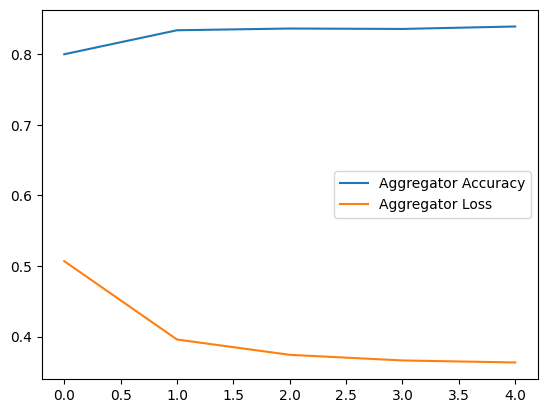

In [22]:
#Visualize federated learning model i.e. final aggregator model
import matplotlib.pyplot as pyplot
pyplot.plot(range(len(aggregator_accuracy)), aggregator_accuracy, label="Aggregator Accuracy")
pyplot.plot(aggregator_loss, label="Aggregator Loss")
pyplot.legend()
pyplot.show()

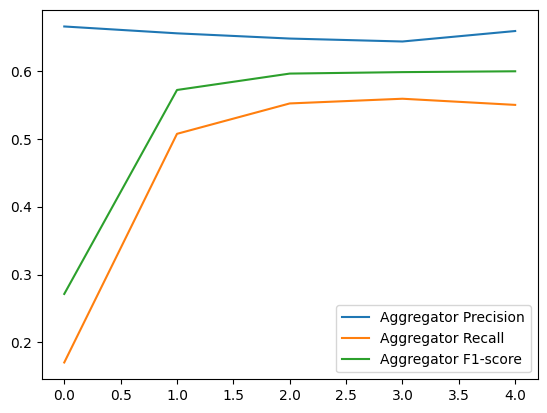

In [23]:
pyplot.plot(range(len(aggregator_precision)), aggregator_precision, label="Aggregator Precision")
pyplot.plot(aggregator_recall, label="Aggregator Recall")
pyplot.plot(aggregator_f1, label="Aggregator F1-score")
pyplot.legend()
pyplot.show()